In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import scipy.signal as sig
import mat73 as matload

import bmfrm.bmfrm2d as bmfrm2d
import bmfrm.trigengines as trig

In [2]:
# Material parameters
c = 1540        # assumed speed of sound in medium [m/s]

# Transducer parameters
dele = 0.298E-3 # element spacing [meters]
nele = 128      # number of elements
fc = 5.208E6    # center frequency [Hz]
lam = c/fc      # wavelength [m]

# Acquisition parameters
fs = 20.833E6   # sampling frequency [Hz]
nacq = 128      # number of acquisitions
tstart = 5 * lam / c    # sample starting point [seconds]
foctx = 28E-3   # focal depth of transmits
focrx = 30E-3   # focal depth of receives

# Reconstruction parameters
dx = 0.298E-3   # beam spacing of pixels [m]
dz = lam/4      # axial spacing of pixels [m]
zmin = 2E-3;    # starting depth for reconstruction
zmax = 60E-3;   # end depth of recon
nz = np.round((zmax-zmin)/dz)   # number of samples
usf = 5         # axial upsampling factor [newsamp/oldsamp]

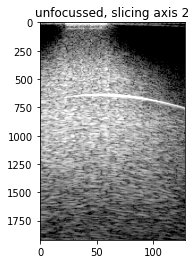

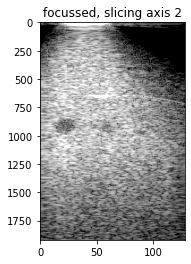

In [3]:
filepw = "C:\\Users\\14142\\OneDrive - Duke University\\Classes\\RIP\\Ultrasound\\unfocused_transmit1.mat"
filefoc = "C:\\Users\\14142\\OneDrive - Duke University\\Classes\\RIP\\Ultrasound\\focused_transmit1.mat"

datapw = matload.loadmat(filepw)['rf']
datapw = datapw.transpose(0, 2, 1)
datafoc = matload.loadmat(filefoc)['rf']

env = np.abs(sig.hilbert(datapw[:,:,40], axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))
plt.figure()
plt.imshow(logged, vmin=-40, vmax=0, aspect=0.1, cmap='gray')
plt.title('unfocussed, slicing axis 2')
plt.show()

env = np.abs(sig.hilbert(datafoc[:,:,40], axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))
plt.figure()
plt.imshow(logged, vmin=-40, vmax=0, aspect=0.1, cmap='gray')
plt.title('focussed, slicing axis 2')
plt.show()

In [4]:
# Define reconstruction grid (space)
x = dx * (np.arange(nacq) - (nacq-1)/2)
y = 0
z = dz * np.arange(nz) + zmin
X, Y, Z = np.meshgrid(x, y, z, indexing='xy')
field = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

# define element locations (space)
x = dele * (np.arange(nele) - (nele-1)/2)
y = 0
z = 0
X, Y, Z = np.meshgrid(x, y, z, indexing='xy')
eles = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

# define rf trace time vector
nt = datafoc.shape[0]
t = tstart + np.arange(nt)/fs

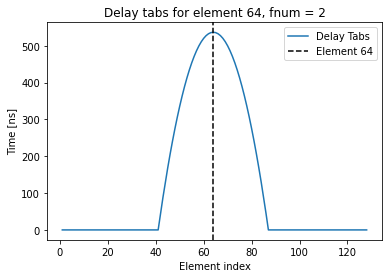

In [5]:
# Verify delay tab calculations are working
ind = 64
dt, mask = trig.dtbyele(c=c, fnum=2, focus = np.array([[(ind-1-(nele-1)/2)*dele, 0, 28E-3]]), eles=eles)
dt[~mask] = 0
plt.figure()
plt.plot(1+np.arange(nele), 1E9*dt, label='Delay Tabs')
plt.title(f'Delay tabs for element {ind}, fnum = 2')
plt.axvline(x=ind, color='k', linestyle='--', label=f'Element {ind}')
plt.ylabel('Time [ns]')
plt.xlabel('Element index')
plt.legend()
plt.show()

In [6]:
# Upsample data
from scipy.signal import resample
datafoc, t = resample(datafoc, nt*usf, t, axis=0)
datapw = resample(datapw, nt*usf, axis=0)
Ts = np.mean(np.diff(t)) # the upsampled sampling period
nt = len(t)

In [33]:
# generate an image from focus data
alines_foc = []
fnum=2
for inde in np.arange(nacq):
    # Calcualte the TX delay tabs
    x_prime = dx * (inde - (nacq-1)/2)
    focus = np.array([[x_prime, 0, foctx]])
    dt_tx, mask_tx = trig.dtbyele(c=c, fnum=fnum, focus=focus, eles=eles)
    dt_tx[~mask_tx] = 0
    
    # Calcualte the RX delay tabs
    focus = np.array([[x_prime, 0, focrx]])
    dt_rx, mask_rx = trig.dtbyele(c=c, fnum=fnum, focus=focus, eles=eles)
    dt_rx[~mask_rx] = 0

    # calculate round trip delays for the focussed transmit
    delay_foc = dt_rx + np.max(dt_tx)
    delay_ind = np.round(delay_foc/Ts)
    dalay_ind = np.array(np.max(delay_ind) - delay_ind, dtype=int)

    # Extract the acq data
    dataacq = datafoc[:,:,inde]
    buffer = np.zeros_like(dataacq)

    # shift each aline by its given shifts
    for col, tab in enumerate(delay_ind):
        buffer[:-int(tab), col] = dataacq[int(tab):, col]

    buffer[:,~mask_rx] = 0
    alines_foc.append(np.sum(buffer, axis=1))

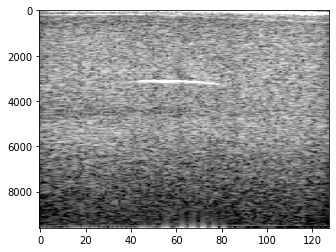

In [34]:
alines_foc = np.array(alines_foc).T
env = np.abs(sig.hilbert(alines_foc, axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))
plt.figure()
plt.imshow(logged, vmin=-40, vmax=0, cmap='gray', aspect=0.01)
plt.show()